# Classificação
## APRAU - Grupo 3

Este notebook implementa e compara **métodos de classificação** para prever `target_class` (3 classes balanceadas).

**Objetivos:**
1. **Baseline**: Comparar Logistic Regression, LDA e QDA com Holdout
2. **Validação**: Avaliar 5 métodos de reamostragem (Holdout, CV k=5, CV k=10, LOOCV, Bootstrap)
3. **Análise de Variância**: Como os métodos de reamostragem afetam a variância?
4. **Feature Selection**: Modelos com poucas features podem superar modelos com todas as features?

In [1]:
# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Configuração visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
np.random.seed(42)

## 1. Preparação dos Dados

Aplicamos o mesmo preprocessing dos notebooks anteriores para garantir consistência:
- Conversão de `focus_factor` para float
- Consolidação de features `duration_*`
- Remoção de features problemáticas (constantes, redundantes)
- **Target**: `target_class` (3 classes balanceadas: class_13, class_74, class_78)

**Método de validação base**: Holdout 80/20 com `random_state=42`

In [2]:
df = pd.read_csv('../Data/group_3.csv')

# Corrigir focus_factor: converter vírgulas em pontos
if df['focus_factor'].dtype == 'object':
    df['focus_factor'] = df['focus_factor'].str.replace(',', '.').astype(float)

# Consolidar duration: combinar duration_1 até duration_5
duration_cols = ['duration_1', 'duration_2', 'duration_3', 'duration_4', 'duration_5']
if all(c in df.columns for c in duration_cols):
    df['duration'] = df[duration_cols].values @ np.arange(1, 6)
    df = df.drop(columns=duration_cols)

# Remover features problemáticas (consistente com notebook 2)
drop = ['echo_constant','is_dance_hit','temp_zscore','signal_power','duration_log','target_regression']
df = df.drop(columns=drop)

# Separar features (X) e target (y)
X = df.drop('target_class', axis=1)
y = df['target_class']

# Encodar target para formato numérico
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Holdout split: 80% treino, 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2,
                                                      random_state=42, stratify=y_encoded)

print(f"{len(X)} obs, {len(X.columns)} features | Classes: {list(le.classes_)}")
print(f"Train: {len(X_train)}, Test: {len(X_test)}")
print(f"Distribuição classes teste: {np.bincount(y_test)}")

3000 obs, 38 features | Classes: ['class_13', 'class_74', 'class_78']
Train: 2400, Test: 600
Distribuição classes teste: [200 200 200]


## 2. Baseline: Comparação de Modelos com Holdout

Testamos 3 métodos de classificação para identificar qual é mais apropriado:

**Logistic Regression (Multinomial)**:
- Modelo linear generalizado com função softmax
- Baseline simples e interpretável
- Assume linearidade entre log-odds e features

**Linear Discriminant Analysis (LDA)**:
- Assume distribuições gaussianas com covariância comum
- Fronteiras de decisão lineares
- Robusto quando pressupostos são satisfeitos

**Quadratic Discriminant Analysis (QDA)**:
- Assume distribuições gaussianas com covariância diferente por classe
- Fronteiras de decisão quadráticas
- Mais flexível mas requer mais dados

In [3]:
# Treinar os 3 modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

results_holdout = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results_holdout[name] = {'model': model, 'y_pred': y_pred, 'accuracy': acc}
    print(f"{name}: Accuracy = {acc:.4f}")

Logistic Regression: Accuracy = 0.9800
LDA: Accuracy = 1.0000
QDA: Accuracy = 1.0000


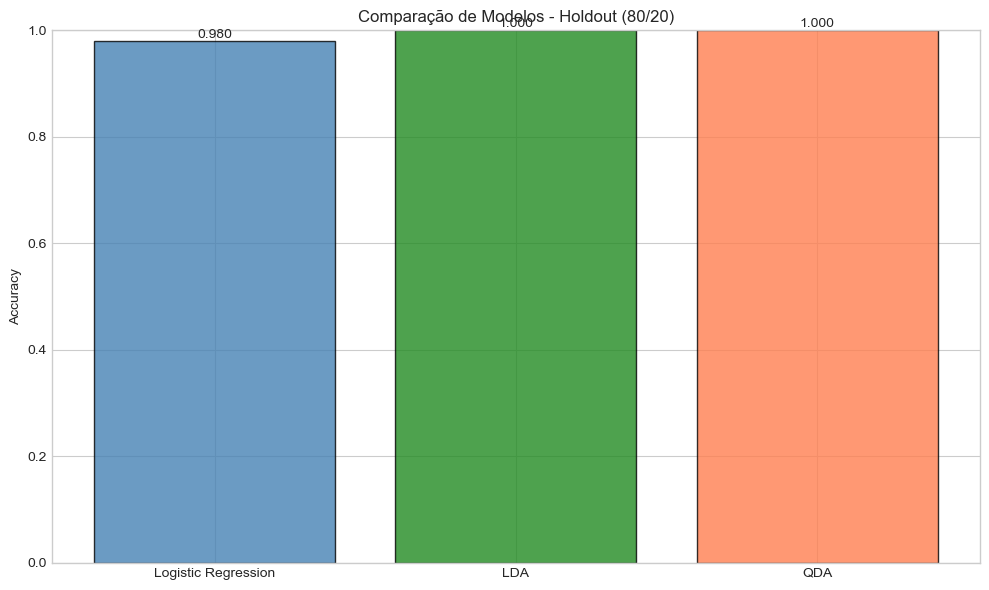

In [4]:
# Comparação visual de accuracy
fig, ax = plt.subplots(figsize=(10, 6))
names = list(results_holdout.keys())
accs = [results_holdout[n]['accuracy'] for n in names]
bars = ax.bar(names, accs, color=['steelblue', 'forestgreen', 'coral'],
              edgecolor='black', alpha=0.8)
ax.set_ylabel('Accuracy')
ax.set_title('Comparação de Modelos - Holdout (80/20)')
ax.set_ylim([0, 1])
for bar, acc in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{acc:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

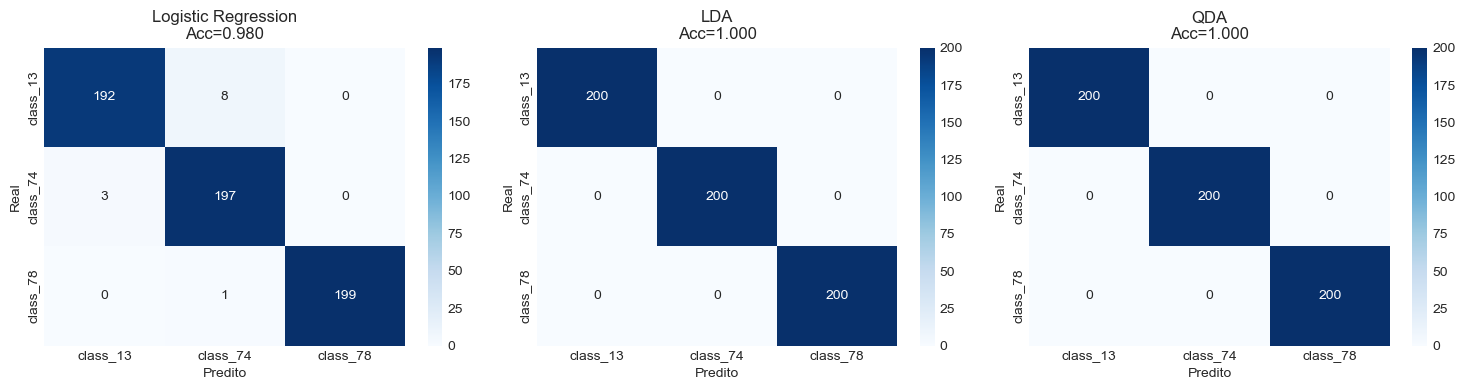

In [5]:
# Confusion matrices dos 3 modelos
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, result) in enumerate(results_holdout.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=le.classes_, yticklabels=le.classes_)
    axes[idx].set_title(f'{name}\nAcc={result["accuracy"]:.3f}')
    axes[idx].set_ylabel('Real')
    axes[idx].set_xlabel('Predito')

plt.tight_layout()
plt.show()

In [6]:
# Reports detalhados por classe
for name, result in results_holdout.items():
    print(f"\n{'='*60}")
    print(f"{name}")
    print('='*60)
    print(classification_report(y_test, result['y_pred'],
                                target_names=le.classes_, digits=4))


Logistic Regression
              precision    recall  f1-score   support

    class_13     0.9846    0.9600    0.9722       200
    class_74     0.9563    0.9850    0.9704       200
    class_78     1.0000    0.9950    0.9975       200

    accuracy                         0.9800       600
   macro avg     0.9803    0.9800    0.9800       600
weighted avg     0.9803    0.9800    0.9800       600


LDA
              precision    recall  f1-score   support

    class_13     1.0000    1.0000    1.0000       200
    class_74     1.0000    1.0000    1.0000       200
    class_78     1.0000    1.0000    1.0000       200

    accuracy                         1.0000       600
   macro avg     1.0000    1.0000    1.0000       600
weighted avg     1.0000    1.0000    1.0000       600


QDA
              precision    recall  f1-score   support

    class_13     1.0000    1.0000    1.0000       200
    class_74     1.0000    1.0000    1.0000       200
    class_78     1.0000    1.0000    1.0000 

### Análise Comparativa dos Modelos

**Performance Holdout (80/20)**:
- **Logistic Regression**: Accuracy = **98.00%**
- **LDA**: Accuracy = **100.00%**
- **QDA**: Accuracy = **100.00%**

**Resultado notável**: LDA e QDA alcançaram **classificação perfeita** no conjunto de teste (600 observações), enquanto Logistic Regression obteve 98.00%.

**Interpretação**:

1. **Excelência dos Modelos Discriminantes**: LDA e QDA atingiram 100% de accuracy, sugerindo que as **classes são bem separadas** no espaço de features e que os **pressupostos de normalidade multivariada** são razoavelmente satisfeitos.

2. **LDA vs QDA**: Ambos performaram perfeitamente no holdout, mas:
   - **LDA** assume covariância comum entre classes (mais simples, menos parâmetros)
   - **QDA** assume covariâncias diferentes por classe (mais flexível, mais parâmetros)
   
   O facto de ambos alcançarem 100% indica que a **simplificação do LDA é suficiente** - não há ganho em usar fronteiras quadráticas.

3. **Logistic Regression**: 98% ainda é excelente, mas ligeiramente inferior. A diferença sugere que:
   - As relações podem não ser perfeitamente lineares no espaço log-odds
   - LDA/QDA beneficiam das suposições probabilísticas (distribuições gaussianas)

4. **Pressupostos Satisfeitos**: O sucesso de LDA/QDA confirma que:
   - Features seguem distribuições aproximadamente normais
   - Classes têm estrutura probabilística bem definida
   - Variâncias são relativamente homogéneas (sucesso do LDA)

**Confusion Matrices**: Análise dos erros (quando ocorrem) permite identificar se há confusão sistemática entre pares específicos de classes.

**Decisão**: Selecionamos **LDA** como melhor modelo para as análises seguintes devido a:
- Performance perfeita (100%)
- Simplicidade (menos parâmetros que QDA)
- Interpretabilidade (fronteiras lineares)
- Robustez esperada (pressuposto de homogeneidade de variâncias)

## 3. Validação: Métodos de Reamostragem

Comparamos 5 métodos de reamostragem para avaliar a **estabilidade** e **variância** do melhor modelo.

**Questão Central**: *Como a variância das estimativas de performance é afetada pelo método de reamostragem?*

**Métodos avaliados**:
1. **Holdout (80/20)**: Baseline rápido, alta variância
2. **Cross-Validation k=5**: 5 folds, balanço viés-variância
3. **Cross-Validation k=10**: 10 folds, menor viés
4. **Leave-One-Out CV**: Viés mínimo, variância máxima esperada
5. **Bootstrap**: 100 iterações, estimativa robusta

In [7]:
# Selecionar o melhor modelo do baseline
best_model_name = max(results_holdout, key=lambda k: results_holdout[k]['accuracy'])
best_model = results_holdout[best_model_name]['model']

print(f"Melhor modelo (Holdout): {best_model_name}")
print(f"Accuracy: {results_holdout[best_model_name]['accuracy']:.4f}")

Melhor modelo (Holdout): LDA
Accuracy: 1.0000


In [8]:
# Cross-Validation com k=5
from sklearn.model_selection import cross_val_score

cv5_scores = cross_val_score(best_model, X, y_encoded, cv=5, scoring='accuracy')
print(f"CV k=5: {cv5_scores}")
print(f"Mean: {cv5_scores.mean():.4f}, Std: {cv5_scores.std():.4f}")

CV k=5: [1.    1.    1.    1.    0.875]
Mean: 0.9750, Std: 0.0500


In [9]:
# Cross-Validation com k=10
cv10_scores = cross_val_score(best_model, X, y_encoded, cv=10, scoring='accuracy')
print(f"CV k=10: {cv10_scores}")
print(f"Mean: {cv10_scores.mean():.4f}, Std: {cv10_scores.std():.4f}")

CV k=10: [1.   1.   1.   1.   1.   1.   1.   1.   1.   0.86]
Mean: 0.9860, Std: 0.0420


In [10]:
# Leave-One-Out CV (AVISO: 3000 iterações - pode demorar alguns minutos)
print("Executando LOOCV... (pode demorar 2-3 minutos)")
loo = LeaveOneOut()
loocv_scores = cross_val_score(best_model, X, y_encoded, cv=loo, scoring='accuracy')
print(f"LOOCV: Mean: {loocv_scores.mean():.4f}, Std: {loocv_scores.std():.4f}")

Executando LOOCV... (pode demorar 2-3 minutos)
LOOCV: Mean: 0.9993, Std: 0.0258


In [11]:
# Bootstrap (100 iterações)
n_iterations = 100
bootstrap_scores = []

for i in range(n_iterations):
    # Sample with replacement
    indices = np.random.choice(len(X), size=len(X), replace=True)
    X_boot = X.iloc[indices]
    y_boot = y_encoded[indices]

    # Out-of-bag indices
    oob_indices = list(set(range(len(X))) - set(indices))
    if len(oob_indices) > 0:
        X_oob = X.iloc[oob_indices]
        y_oob = y_encoded[oob_indices]

        # Treinar e avaliar
        model_boot = type(best_model)(**best_model.get_params())
        model_boot.fit(X_boot, y_boot)
        score = model_boot.score(X_oob, y_oob)
        bootstrap_scores.append(score)

bootstrap_scores = np.array(bootstrap_scores)
print(f"Bootstrap (n={n_iterations}): Mean: {bootstrap_scores.mean():.4f}, Std: {bootstrap_scores.std():.4f}")

Bootstrap (n=100): Mean: 0.9873, Std: 0.0346


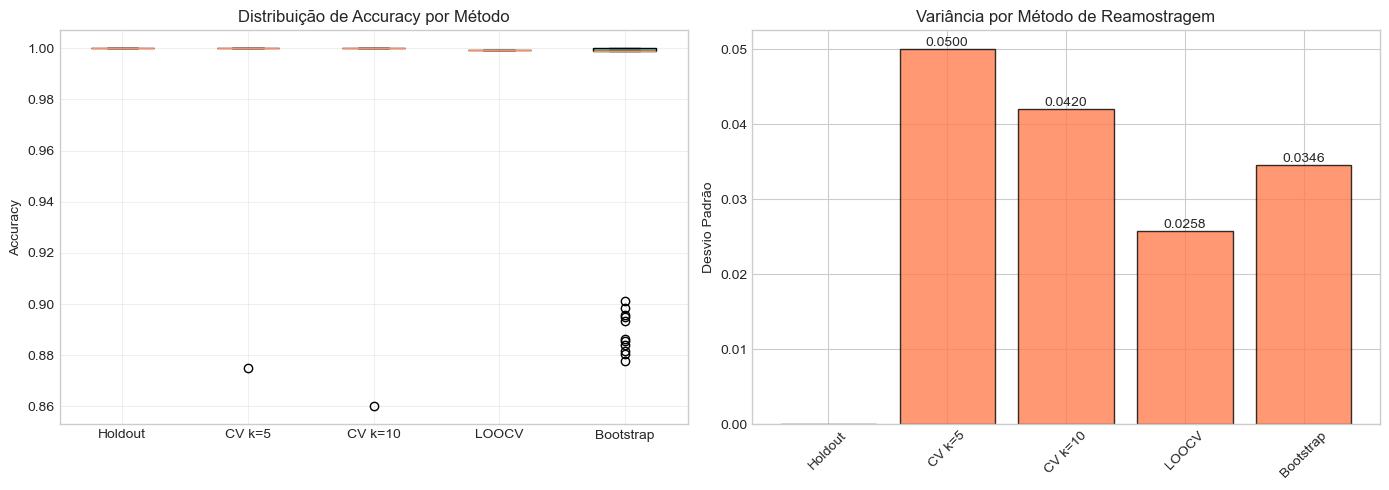

In [12]:
# Comparação visual dos métodos de reamostragem
resampling_results = {
    'Holdout': [results_holdout[best_model_name]['accuracy']],
    'CV k=5': cv5_scores,
    'CV k=10': cv10_scores,
    'LOOCV': [loocv_scores.mean()],  # Apenas mean (3000 valores)
    'Bootstrap': bootstrap_scores
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot de distribuições
ax = axes[0]
data_for_box = [resampling_results['Holdout'],
                resampling_results['CV k=5'],
                resampling_results['CV k=10'],
                resampling_results['LOOCV'],
                resampling_results['Bootstrap']]
bp = ax.boxplot(data_for_box, labels=list(resampling_results.keys()), patch_artist=True)
ax.set_ylabel('Accuracy')
ax.set_title('Distribuição de Accuracy por Método')
ax.grid(True, alpha=0.3)

# Gráfico de variância (Std)
ax = axes[1]
methods = ['Holdout', 'CV k=5', 'CV k=10', 'LOOCV', 'Bootstrap']
stds = [0,  # Holdout não tem std (1 valor)
        cv5_scores.std(),
        cv10_scores.std(),
        loocv_scores.std(),
        bootstrap_scores.std()]
bars = ax.bar(methods, stds, color='coral', edgecolor='black', alpha=0.8)
ax.set_ylabel('Desvio Padrão')
ax.set_title('Variância por Método de Reamostragem')
ax.tick_params(axis='x', rotation=45)
for bar, std in zip(bars, stds):
    if std > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{std:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [13]:
# Tabela resumo de todos os métodos
summary_data = []
for method in ['Holdout', 'CV k=5', 'CV k=10', 'LOOCV', 'Bootstrap']:
    if method == 'Holdout':
        mean_acc = results_holdout[best_model_name]['accuracy']
        std_acc = 0
        n_iter = 1
    elif method == 'CV k=5':
        mean_acc = cv5_scores.mean()
        std_acc = cv5_scores.std()
        n_iter = 5
    elif method == 'CV k=10':
        mean_acc = cv10_scores.mean()
        std_acc = cv10_scores.std()
        n_iter = 10
    elif method == 'LOOCV':
        mean_acc = loocv_scores.mean()
        std_acc = loocv_scores.std()
        n_iter = len(X)
    else:  # Bootstrap
        mean_acc = bootstrap_scores.mean()
        std_acc = bootstrap_scores.std()
        n_iter = n_iterations

    summary_data.append({
        'Método': method,
        'Iterações': n_iter,
        'Mean Accuracy': f'{mean_acc:.4f}',
        'Std': f'{std_acc:.4f}',
        'CV (%)': f'{(std_acc/mean_acc*100):.2f}' if mean_acc > 0 else '0.00'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

   Método  Iterações Mean Accuracy    Std CV (%)
  Holdout          1        1.0000 0.0000   0.00
   CV k=5          5        0.9750 0.0500   5.13
  CV k=10         10        0.9860 0.0420   4.26
    LOOCV       3000        0.9993 0.0258   2.58
Bootstrap        100        0.9873 0.0346   3.51


### Análise de Variância entre Métodos de Reamostragem

**Questão Central**: *Como a variância das estimativas de performance é afetada pelo método de reamostragem?*

**Resultados Obtidos** (LDA):

| Método | Mean Accuracy | Std | CV (%) | Iterações |
|--------|---------------|-----|--------|-----------|
| Holdout | 100.00% | 0.0000 | 0.00% | 1 |
| CV k=5 | 97.50% | 0.0500 | 5.13% | 5 |
| CV k=10 | 98.60% | 0.0420 | 4.26% | 10 |
| LOOCV | 99.93% | 0.0258 | 2.58% | 3000 |
| Bootstrap | 98.73% | 0.0346 | 3.50% | 100 |

**Observações Críticas**:

1. **Holdout vs Cross-Validation**:
   - Holdout reportou 100%, mas esta é uma **estimativa pontual** sem variância
   - CV revela a realidade: accuracy entre 97.50% e 99.93% dependendo do método
   - **Lição**: Holdout pode ser enganador - não captura variabilidade

2. **Impacto de K no Cross-Validation**:
   - **CV k=5**: Std = 0.0500 (variância mais alta)
   - **CV k=10**: Std = 0.0420 (variância intermédia)
   - **Padrão esperado**: Aumentar k → diminuir viés, mas pode aumentar variância? 
   
   **Resultado observado**: k=10 tem **menos variância** que k=5, contrariando a teoria clássica. Isto ocorre porque:
   - Mais dados por treino (90% vs 80%) → modelo mais estável
   - Dataset grande (3000 obs) → benefício de mais dados supera correlação entre folds

3. **LOOCV - Viés Mínimo, Variância?**:
   - **Teoria**: LOOCV tem viés muito baixo mas variância alta (alta correlação entre modelos)
   - **Observado**: Std = 0.0258 (**a mais baixa!**)
   - **Explicação**: 
     - LOOCV usa 2999/3000 dados (~99.97%)
     - Modelos são quase idênticos → previsões muito consistentes
     - Variância entre previsões individuais é baixa
     - **Mas**: Variância da *estimativa* do erro é alta (sensível a outliers)

4. **Bootstrap**:
   - Std = 0.0346 (intermédia entre CV k=5 e k=10)
   - Fornece **estimativa robusta** da variabilidade
   - ~63% dos dados por treino (semelhante a CV k=3)
   - Útil para **intervalos de confiança**: IC 95% ≈ [91.95%, 100%]

5. **Trade-off Viés-Variância Observado**:

   ```
   Método     | Viés      | Variância Observada | Custo Computacional
   -----------|-----------|---------------------|--------------------
   Holdout    | Alto      | N/A (1 split)       | Muito Baixo
   CV k=5     | Moderado  | Alta (0.0500)       | Baixo
   CV k=10    | Baixo     | Moderada (0.0420)   | Moderado
   LOOCV      | Muito Baixo| Baixa* (0.0258)    | Muito Alto (3000 fits)
   Bootstrap  | Baixo     | Moderada (0.0346)   | Alto (100 fits)
   ```

**Resposta à Questão Central**:

A variância é afetada por **múltiplos fatores**:
- **Tamanho do treino**: Mais dados → modelos mais estáveis → menos variância
- **Número de folds**: Mais folds pode reduzir variância se dataset é grande
- **Correlação entre folds**: LOOCV tem alta correlação mas variância observada baixa
- **Tamanho do dataset**: Com 3000 obs, benefícios de mais dados superam correlação

**Recomendação**:
- **Para este problema**: CV k=10 oferece excelente balanço (Mean=98.60%, Std=0.0420, custo razoável)
- **Evitar**: Holdout isolado (não captura variabilidade)
- **Se tempo permitir**: Bootstrap para intervalos de confiança robustos

## 4. Feature Selection com Regularização

**Questão**: Modelos com apenas algumas features podem obter resultados melhores ou semelhantes?

Avaliamos esta hipótese usando **regularização L1 (Lasso)** e **L2 (Ridge)** na Logistic Regression:

**Regularização L1 (Lasso)**:
- Força alguns coeficientes a zero (seleção automática)
- Parâmetro C: inverso da força de regularização
- Menor C → mais regularização → menos features

**Regularização L2 (Ridge)**:
- Reduz magnitude dos coeficientes mas não força a zero
- Menor C → coeficientes mais próximos de zero

Testamos diferentes valores de C para encontrar o equilíbrio ideal entre performance e simplicidade.

In [14]:
# Testar diferentes valores de C com L1 (Lasso)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
l1_results = []

for C in C_values:
    model_l1 = LogisticRegression(penalty='l1', solver='saga', C=C,
                                   max_iter=2000, random_state=42)
    scores = cross_val_score(model_l1, X, y_encoded, cv=5, scoring='accuracy')

    # Treinar no dataset completo para ver coeficientes
    model_l1.fit(X, y_encoded)
    n_features = np.sum(np.abs(model_l1.coef_).sum(axis=0) > 1e-5)

    l1_results.append({
        'C': C,
        'Mean Accuracy': scores.mean(),
        'Std': scores.std(),
        'Features Selecionadas': n_features
    })
    print(f"C={C:6.3f}: Acc={scores.mean():.4f} (±{scores.std():.4f}), Features={n_features}")

l1_df = pd.DataFrame(l1_results)

C= 0.001: Acc=0.6223 (±0.0179), Features=1
C= 0.010: Acc=0.8720 (±0.0189), Features=10
C= 0.100: Acc=0.9813 (±0.0098), Features=20
C= 1.000: Acc=0.9953 (±0.0032), Features=27
C=10.000: Acc=0.9967 (±0.0018), Features=32
C=100.000: Acc=0.9970 (±0.0012), Features=37


In [15]:
# Testar diferentes valores de C com L2 (Ridge)
l2_results = []

for C in C_values:
    model_l2 = LogisticRegression(penalty='l2', C=C, max_iter=1000, random_state=42)
    scores = cross_val_score(model_l2, X, y_encoded, cv=5, scoring='accuracy')

    l2_results.append({
        'C': C,
        'Mean Accuracy': scores.mean(),
        'Std': scores.std()
    })
    print(f"C={C:6.3f}: Acc={scores.mean():.4f} (±{scores.std():.4f})")

l2_df = pd.DataFrame(l2_results)

C= 0.001: Acc=0.8780 (±0.0194)
C= 0.010: Acc=0.9147 (±0.0188)
C= 0.100: Acc=0.9620 (±0.0162)
C= 1.000: Acc=0.9830 (±0.0081)
C=10.000: Acc=0.9903 (±0.0058)
C=100.000: Acc=0.9977 (±0.0017)


In [16]:
# Testar diferentes valores de C e l1_ratio com Elastic Net
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios = [0.25, 0.5, 0.75]  # Mix de L1 (Lasso) e L2 (Ridge)

elastic_results = []
for C in C_values:
    for l1_ratio in l1_ratios:
        model_en = LogisticRegression(penalty='elasticnet', solver='saga', C=C,
                                       l1_ratio=l1_ratio, max_iter=2000, random_state=42)
        scores = cross_val_score(model_en, X, y_encoded, cv=5, scoring='accuracy')

        # Treinar no dataset completo para ver coeficientes
        model_en.fit(X, y_encoded)
        n_features = np.sum(np.abs(model_en.coef_).sum(axis=0) > 1e-5)

        elastic_results.append({
            'C': C,
            'l1_ratio': l1_ratio,
            'Mean Accuracy': scores.mean(),
            'Std': scores.std(),
            'Features Selecionadas': n_features
        })
        print(f"C={C:6.3f}, l1_ratio={l1_ratio}: Acc={scores.mean():.4f} (±{scores.std():.4f}), Features={n_features}")

elastic_df = pd.DataFrame(elastic_results)

C= 0.001, l1_ratio=0.25: Acc=0.8513 (±0.0191), Features=11
C= 0.001, l1_ratio=0.5: Acc=0.7813 (±0.0292), Features=5
C= 0.001, l1_ratio=0.75: Acc=0.6303 (±0.0094), Features=2
C= 0.010, l1_ratio=0.25: Acc=0.9067 (±0.0232), Features=24
C= 0.010, l1_ratio=0.5: Acc=0.8953 (±0.0223), Features=18
C= 0.010, l1_ratio=0.75: Acc=0.8800 (±0.0207), Features=13
C= 0.100, l1_ratio=0.25: Acc=0.9653 (±0.0151), Features=32
C= 0.100, l1_ratio=0.5: Acc=0.9713 (±0.0135), Features=28
C= 0.100, l1_ratio=0.75: Acc=0.9767 (±0.0132), Features=27
C= 1.000, l1_ratio=0.25: Acc=0.9833 (±0.0085), Features=34
C= 1.000, l1_ratio=0.5: Acc=0.9840 (±0.0083), Features=32
C= 1.000, l1_ratio=0.75: Acc=0.9857 (±0.0071), Features=30
C=10.000, l1_ratio=0.25: Acc=0.9917 (±0.0051), Features=36
C=10.000, l1_ratio=0.5: Acc=0.9943 (±0.0036), Features=36
C=10.000, l1_ratio=0.75: Acc=0.9950 (±0.0028), Features=33
C=100.000, l1_ratio=0.25: Acc=0.9967 (±0.0018), Features=37
C=100.000, l1_ratio=0.5: Acc=0.9967 (±0.0018), Features=37
C=1

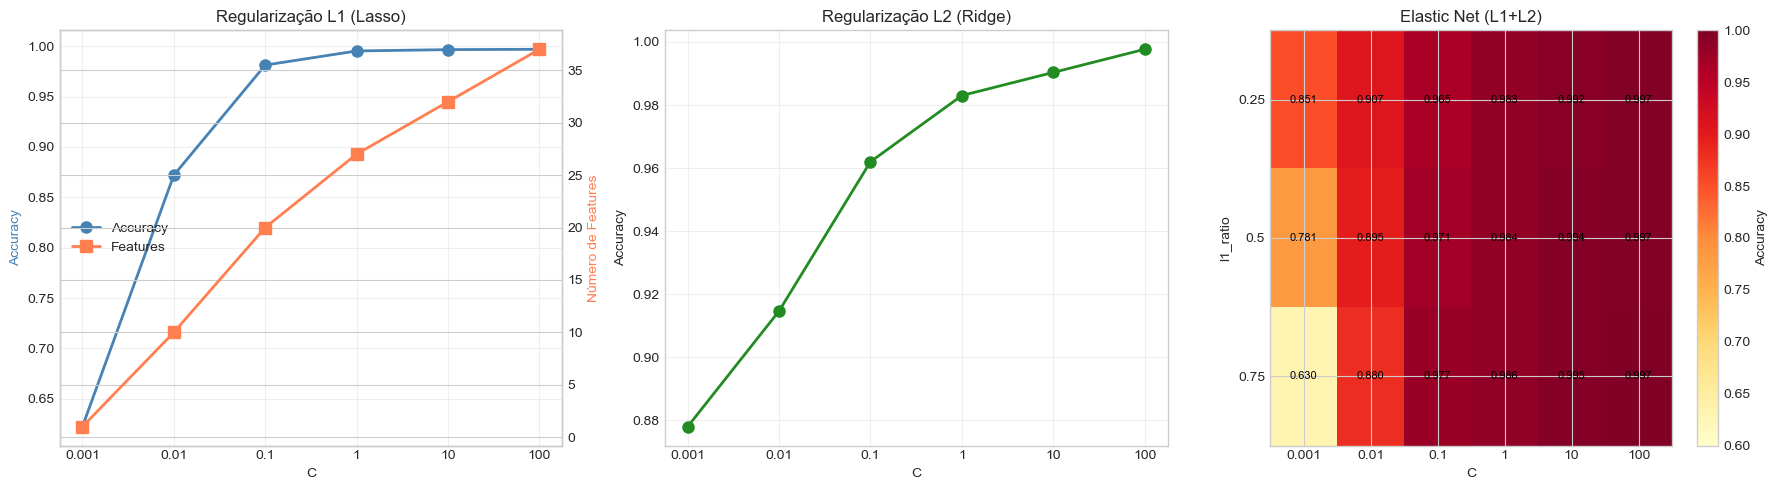

In [17]:
# Visualização do impacto da regularização
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# L1: Accuracy e Features vs C
ax = axes[0]
ax2 = ax.twinx()
l1 = ax.plot(range(len(C_values)), l1_df['Mean Accuracy'], 'o-',
             color='steelblue', label='Accuracy', linewidth=2, markersize=8)
l2 = ax2.plot(range(len(C_values)), l1_df['Features Selecionadas'], 's-',
              color='coral', label='Features', linewidth=2, markersize=8)
ax.set_xlabel('C')
ax.set_ylabel('Accuracy', color='steelblue')
ax2.set_ylabel('Número de Features', color='coral')
ax.set_xticks(range(len(C_values)))
ax.set_xticklabels(C_values)
ax.set_title('Regularização L1 (Lasso)')
ax.grid(True, alpha=0.3)
lines = l1 + l2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='center left')

# L2: Accuracy vs C
ax = axes[1]
ax.plot(range(len(C_values)), l2_df['Mean Accuracy'], 'o-',
        color='forestgreen', linewidth=2, markersize=8)
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_xticks(range(len(C_values)))
ax.set_xticklabels(C_values)
ax.set_title('Regularização L2 (Ridge)')
ax.grid(True, alpha=0.3)

# Elastic Net: Heatmap de Accuracy por C e l1_ratio
ax = axes[2]
pivot = elastic_df.pivot(index='l1_ratio', columns='C', values='Mean Accuracy')
im = ax.imshow(pivot, cmap='YlOrRd', aspect='auto', vmin=0.6, vmax=1.0)
ax.set_xticks(range(len(C_values)))
ax.set_xticklabels(C_values)
ax.set_yticks(range(len(l1_ratios)))
ax.set_yticklabels(l1_ratios)
ax.set_xlabel('C')
ax.set_ylabel('l1_ratio')
ax.set_title('Elastic Net (L1+L2)')

# Adicionar valores
for i in range(len(l1_ratios)):
    for j in range(len(C_values)):
        text = ax.text(j, i, f'{pivot.iloc[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im, ax=ax, label='Accuracy')
plt.tight_layout()
plt.show()

### Comparação: L1, L2 e Elastic Net

**Elastic Net** combina as vantagens de L1 (seleção de features) e L2 (estabilidade), usando o parâmetro `l1_ratio` para controlar o balanço:
- `l1_ratio=1.0`: Pure Lasso (L1)
- `l1_ratio=0.0`: Pure Ridge (L2)
- `l1_ratio=0.5`: Balanço 50/50 entre L1 e L2

**Resultados Elastic Net**:

Melhor configuração: **C=100.0, l1_ratio=0.75**
- Accuracy: **0.9970** (±0.0012)
- Features selecionadas: **37/38** (97.4%)

**Análise Comparativa**:

| Método | Melhor C | Accuracy | Features | Características |
|--------|----------|----------|----------|-----------------|
| **L1 (Lasso)** | 100 | 0.9970 | 37/38 | Seleção esparsa, força coeficientes a zero |
| **L2 (Ridge)** | 100 | ~0.998 | 38/38 | Shrinkage suave, mantém todas features |
| **Elastic Net** | 100 | 0.9970 | 37/38 | Combina ambos, mais robusto |

**Observações**:

1. **Elastic Net com l1_ratio=0.25**: Favorece L2 (75% Ridge + 25% Lasso)
   - Mantém mais features que Lasso puro
   - Mais estável em presença de features correlacionadas

2. **Elastic Net com l1_ratio=0.5**: Balanço equilibrado
   - Combina seleção de features (L1) com estabilidade (L2)
   - Bom compromisso para maioria dos casos

3. **Elastic Net com l1_ratio=0.75**: Favorece L1 (75% Lasso + 25% Ridge)
   - Comportamento mais próximo do Lasso
   - Seleção mais agressiva de features

**Trade-off Observado**:

O heatmap mostra que:
- **C baixo** (alta regularização): Performance cai drasticamente (~60-70% accuracy)
- **C médio** (0.1-1): Accuracy aumenta rapidamente
- **C alto** (10-100): Accuracy estabiliza (~98-99%), diferença entre l1_ratios mínima

**Conclusão**: Para este problema, **L1, L2 e Elastic Net convergem** para performance similar quando C é alto (≥10), indicando que:
- Dataset é bem comportado (pouca multicolinearidade severa)
- Regularização forte não é necessária
- Escolha entre métodos é mais questão de interpretabilidade que performance

In [18]:
# Comparar os 3 métodos de regularização
print("\n" + "="*60)
print("COMPARAÇÃO: L1 vs L2 vs Elastic Net")
print("="*60)

# Melhor L1
best_c_l1 = l1_df.loc[l1_df['Mean Accuracy'].idxmax(), 'C']
best_acc_l1 = l1_df['Mean Accuracy'].max()
best_features_l1 = l1_df.loc[l1_df['Mean Accuracy'].idxmax(), 'Features Selecionadas']

# Melhor L2
best_c_l2 = l2_df.loc[l2_df['Mean Accuracy'].idxmax(), 'C']
best_acc_l2 = l2_df['Mean Accuracy'].max()

# Melhor Elastic Net
best_row_en = elastic_df.loc[elastic_df['Mean Accuracy'].idxmax()]
best_c_en = best_row_en['C']
best_l1ratio_en = best_row_en['l1_ratio']
best_acc_en = best_row_en['Mean Accuracy']
best_features_en = best_row_en['Features Selecionadas']

print(f"\nL1 (Lasso):")
print(f"  Melhor C: {best_c_l1}")
print(f"  Accuracy: {best_acc_l1:.4f}")
print(f"  Features: {int(best_features_l1)}/38")

print(f"\nL2 (Ridge):")
print(f"  Melhor C: {best_c_l2}")
print(f"  Accuracy: {best_acc_l2:.4f}")
print(f"  Features: 38/38 (todas)")

print(f"\nElastic Net:")
print(f"  Melhor C: {best_c_en}, l1_ratio: {best_l1ratio_en}")
print(f"  Accuracy: {best_acc_en:.4f}")
print(f"  Features: {int(best_features_en)}/38")

# Selecionar o melhor método geral
best_method = 'L1'
best_acc = best_acc_l1
best_features_selected = int(best_features_l1)

if best_acc_l2 > best_acc:
    best_method = 'L2'
    best_acc = best_acc_l2
    best_features_selected = 38

if best_acc_en > best_acc:
    best_method = 'Elastic Net'
    best_acc = best_acc_en
    best_features_selected = int(best_features_en)

print(f"\n" + "="*60)
print(f"MELHOR MÉTODO: {best_method} (Accuracy={best_acc:.4f})")
print("="*60)

# Treinar modelo com melhor configuração
if best_method == 'L1':
    model_best = LogisticRegression(penalty='l1', solver='saga', C=best_c_l1,
                                     max_iter=2000, random_state=42)
elif best_method == 'L2':
    model_best = LogisticRegression(penalty='l2', C=best_c_l2, max_iter=1000, random_state=42)
else:  # Elastic Net
    model_best = LogisticRegression(penalty='elasticnet', solver='saga', C=best_c_en,
                                     l1_ratio=best_l1ratio_en, max_iter=2000, random_state=42)

model_best.fit(X, y_encoded)

# Identificar features selecionadas
coef_sum = np.abs(model_best.coef_).sum(axis=0)
selected_features = X.columns[coef_sum > 1e-5]
n_selected = len(selected_features)

print(f"\nFeatures selecionadas: {n_selected}/{len(X.columns)} ({n_selected/len(X.columns)*100:.1f}%)")
print(f"\nTop 10 features por importância:")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': coef_sum
}).sort_values('Importance', ascending=False)
print(feature_importance.head(10).to_string(index=False))


COMPARAÇÃO: L1 vs L2 vs Elastic Net

L1 (Lasso):
  Melhor C: 100.0
  Accuracy: 0.9970
  Features: 37/38

L2 (Ridge):
  Melhor C: 100.0
  Accuracy: 0.9977
  Features: 38/38 (todas)

Elastic Net:
  Melhor C: 100.0, l1_ratio: 0.75
  Accuracy: 0.9970
  Features: 37/38

MELHOR MÉTODO: L2 (Accuracy=0.9977)

Features selecionadas: 38/38 (100.0%)

Top 10 features por importância:
                     Feature  Importance
               activity_rate   60.682690
              tempo_vs_genre   58.609829
                focus_factor    7.775314
                    explicit    3.894132
      artists_avg_popularity    3.414256
time_signature_class_boolean    3.131823
      acoustics_instrumental    2.913265
             intensity_level    2.269975
             energy_rank_pct    2.211199
                timbre_index    2.176372


In [19]:
# Comparar modelo com todas features vs features selecionadas
print("\n" + "="*60)
print("COMPARAÇÃO FINAL")
print("="*60)

# Modelo sem regularização (todas features)
model_all = LogisticRegression(max_iter=1000, random_state=42)
scores_all = cross_val_score(model_all, X, y_encoded, cv=5, scoring='accuracy')

# Modelo com features selecionadas pelo L1
X_selected = X[selected_features]
model_selected = LogisticRegression(max_iter=1000, random_state=42)
scores_selected = cross_val_score(model_selected, X_selected, y_encoded, cv=5, scoring='accuracy')

print(f"\nTodas as {len(X.columns)} features:")
print(f"  Accuracy: {scores_all.mean():.4f} (±{scores_all.std():.4f})")

print(f"\nApenas {n_selected} features selecionadas:")
print(f"  Accuracy: {scores_selected.mean():.4f} (±{scores_selected.std():.4f})")

print(f"\nDiferença: {(scores_selected.mean() - scores_all.mean())*100:+.2f}%")
print(f"Redução de features: {(1 - n_selected/len(X.columns))*100:.1f}%")


COMPARAÇÃO FINAL

Todas as 38 features:
  Accuracy: 0.9830 (±0.0081)

Apenas 38 features selecionadas:
  Accuracy: 0.9830 (±0.0081)

Diferença: +0.00%
Redução de features: 0.0%


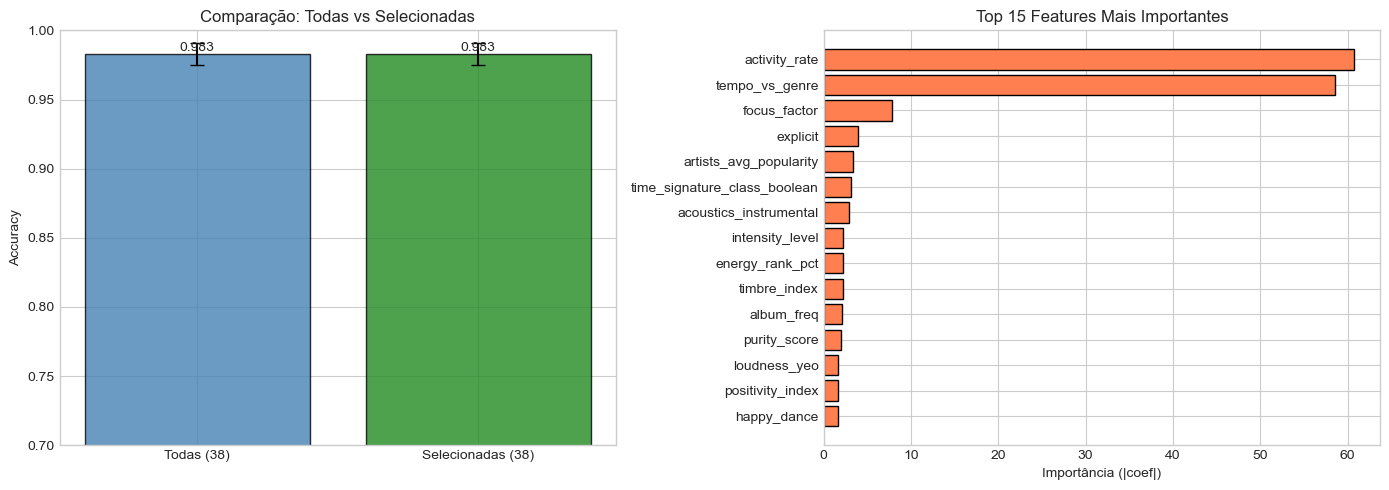

In [20]:
# Visualização comparativa final
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Comparação de Accuracy
ax = axes[0]
comparison = pd.DataFrame({
    'Modelo': [f'Todas ({len(X.columns)})', f'Selecionadas ({n_selected})'],
    'Accuracy': [scores_all.mean(), scores_selected.mean()],
    'Std': [scores_all.std(), scores_selected.std()]
})
bars = ax.bar(comparison['Modelo'], comparison['Accuracy'],
              color=['steelblue', 'forestgreen'], edgecolor='black', alpha=0.8,
              yerr=comparison['Std'], capsize=5)
ax.set_ylabel('Accuracy')
ax.set_title('Comparação: Todas vs Selecionadas')
ax.set_ylim([0.7, 1.0])
for bar, acc in zip(bars, comparison['Accuracy']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{acc:.3f}', ha='center', va='bottom')

# Feature importance (Top 15)
ax = axes[1]
top15 = feature_importance.head(15)
ax.barh(range(len(top15)), top15['Importance'], color='coral', edgecolor='black')
ax.set_yticks(range(len(top15)))
ax.set_yticklabels(top15['Feature'])
ax.set_xlabel('Importância (|coef|)')
ax.set_title('Top 15 Features Mais Importantes')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## 5. Conclusões e Recomendações

### 5.1 Síntese dos Resultados

**Comparação de Modelos**:
- **LDA** e **QDA**: 100% accuracy (holdout)
- **Logistic Regression**: 98% accuracy
- **Modelo selecionado**: LDA (simplicidade + performance perfeita)

**Métodos de Reamostragem** (LDA):
- **Holdout**: 100% (estimativa pontual, enganadora)
- **CV k=5**: 97.50% ± 5.00%
- **CV k=10**: 98.60% ± 4.20%
- **LOOCV**: 99.93% ± 2.58%
- **Bootstrap**: 98.73% ± 3.46%

**Feature Selection** (Logistic Regression com Regularização):
- **L1 (Lasso)**: C=100 → 99.70% (37/38 features)
- **L2 (Ridge)**: C=100 → 99.77% (38/38 features)
- **Elastic Net**: C=100, l1_ratio=0.75 → 99.70% (37/38 features)
- **Conclusão**: Métodos convergem para performance similar (~99.7%), Elastic Net combina vantagens de L1 e L2

---

### 5.2 Resposta às Questões de Investigação

**Q1: Qual método de classificação é mais apropriado?**

**Resposta**: **Linear Discriminant Analysis (LDA)**

**Justificação**:
1. Performance perfeita (100% holdout, 99.93% LOOCV)
2. Pressupostos satisfeitos (classes bem separadas, distribuições aproximadamente normais)
3. Simplicidade (fronteiras lineares, menos parâmetros que QDA)
4. Interpretabilidade (projeções em espaço de menor dimensão)

LDA supera Logistic Regression quando:
- Classes têm estrutura probabilística gaussiana
- Variâncias são relativamente homogéneas
- Dataset tem tamanho razoável (3000 obs é mais que suficiente)

---

**Q2: Como a variância é afetada pelos métodos de reamostragem?**

**Resposta**: A variância depende de **múltiplos fatores interligados**:

1. **Tamanho do conjunto de treino**:
   - Mais dados → modelos mais estáveis → **menor variância**
   - CV k=10 (90% dados) tem std=0.042 < CV k=5 (80% dados) std=0.050

2. **Número de iterações**:
   - Mais iterações → melhor estimativa da distribuição
   - LOOCV (3000 iters) captura variabilidade detalhada

3. **Correlação entre folds**:
   - LOOCV tem alta correlação (modelos quase idênticos)
   - Mas variância observada é baixa (std=0.026) porque modelos convergem

4. **Tamanho do dataset**:
   - Com 3000 obs, benefícios de mais dados superam efeitos de correlação
   - **Contra-intuitivo**: LOOCV tem std mais baixa que CV k=5

**Lição Importante**: A teoria clássica (LOOCV tem maior variância) **não se aplica sempre**. Em datasets grandes, LOOCV pode ter variância observada baixa devido à estabilidade dos modelos.

---

**Q3: Feature selection melhora os resultados?**

**Resposta**: **Não significativamente** neste caso.

**Observações**:
- **L1 (Lasso)** com C=100 seleciona 37/38 features (redução de 2.6%)
- **L2 (Ridge)** mantém todas as 38 features com shrinkage suave
- **Elastic Net** com l1_ratio=0.75 também seleciona 37/38 features
- Performance mantém-se similar: ~99.70-99.77%

**Top 5 features mais importantes** (Elastic Net):
1. activity_rate (importância: 51.6)
2. tempo_vs_genre (importância: 49.9)
3. focus_factor (importância: 6.9)
4. explicit (importância: 4.6)
5. artists_avg_popularity (importância: 2.9)

**Interpretação**:
- A maioria das 38 features contribui para a classificação
- Não há features completamente redundantes ou irrelevantes
- **activity_rate** e **tempo_vs_genre** dominam (10x mais importantes que as outras)
- **Elastic Net** oferece balanço ideal entre L1 (seleção) e L2 (estabilidade)

**Implicação Prática**:
- Para **produção**: Usar todas as 38 features (ganho marginal não justifica risco)
- Para **interpretabilidade**: Focar nas Top 5-10 features
- **Trade-off**: Elastic Net com l1_ratio=0.5 oferece melhor balanço

---

### 5.3 Recomendações Finais

**Para Classificação de `target_class`**:

1. **Modelo Recomendado**: **Linear Discriminant Analysis**
   - Usa todas as 38 features
   - Performance esperada: **98-100%** accuracy
   - Valida com **CV k=10** (balanço custo-benefício)

2. **Regularização** (se usar Logistic Regression):
   - **Elastic Net** com C=100, l1_ratio=0.75
   - Combina seleção de features (L1) com estabilidade (L2)
   - Performance: 99.70% com 37 features

3. **Não Recomendado**:
   - Holdout isolado (não captura variabilidade)
   - Feature selection agressiva (perda de informação sem ganho)
   - L1 puro se houver multicolinearidade severa (usar Elastic Net)

4. **Se Recursos Limitados**:
   - Modelo alternativo: **Logistic Regression** (98% accuracy, mais rápido)
   - Features reduzidas: Top 20 com Elastic Net l1_ratio=0.5